In [67]:
import csv
import numpy as np
import os
import sys
import tensorflow as tf
from tensorflow.python.client import device_lib
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop



import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.rcParams.update({'font.size': 12, 'figure.max_open_warning': 0})
plt.rc("figure", dpi=100)
plt.style.use("seaborn-whitegrid")

print(tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

2.3.0
Num GPUs: 0


In [2]:
# Check available datasets
tfds.list_builders()

['abstract_reasoning',
 'aeslc',
 'aflw2k3d',
 'ai2_arc',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'cos_e',
 'cosmos_qa',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiabank',
 'diabetic_retinopathy_detection',
 'div2k',
 'dmlab',
 'downsampled_imagenet',
 'dsprites',
 'dtd',
 'duke_ultrasound',
 'emnist',
 'eraser_multi_rc',
 'esnli',
 'eurosat',
 'fashion_mnist

In [56]:
(train_ds, val_ds), metadata = tfds.load(
    'horses_or_humans',
    split=['train', 'test'],
    with_info=True,
    as_supervised=True,
)

In [4]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

2


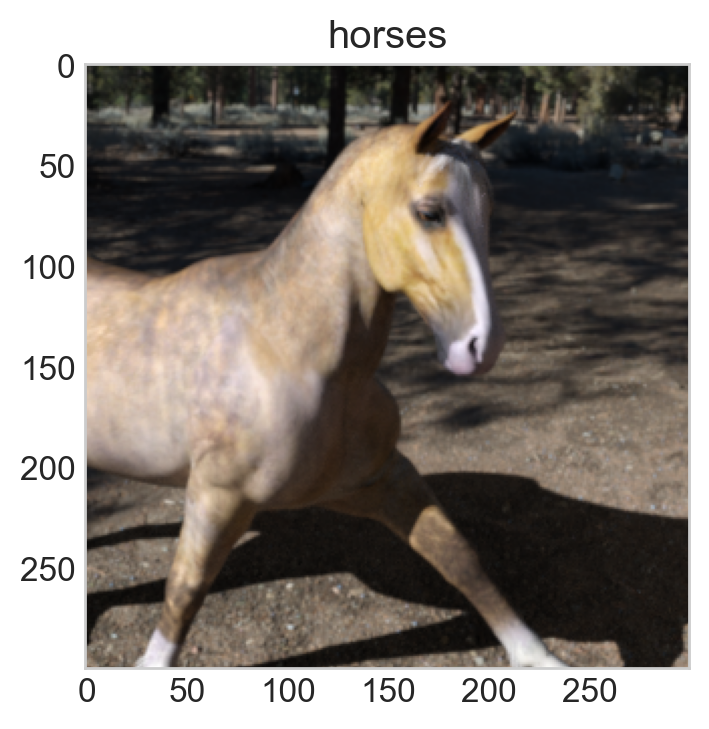

In [57]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))
plt.grid(False)

In [58]:
IMG_SIZE = 150

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1. / 255)
])

In [113]:
batch_size = 32


def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
                num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Batch all datasets
    ds = ds.batch(batch_size)

    # Use data augmentation only on the training set
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y))

    # Use buffered prefecting on all datasets
    return ds.prefetch(1)

In [69]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.4),
    layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.2,
                                                                      0.2),
                                                        width_factor=(-0.2,
                                                                      0.2)),
    layers.experimental.preprocessing.RandomZoom(0.2, 0.2),
])

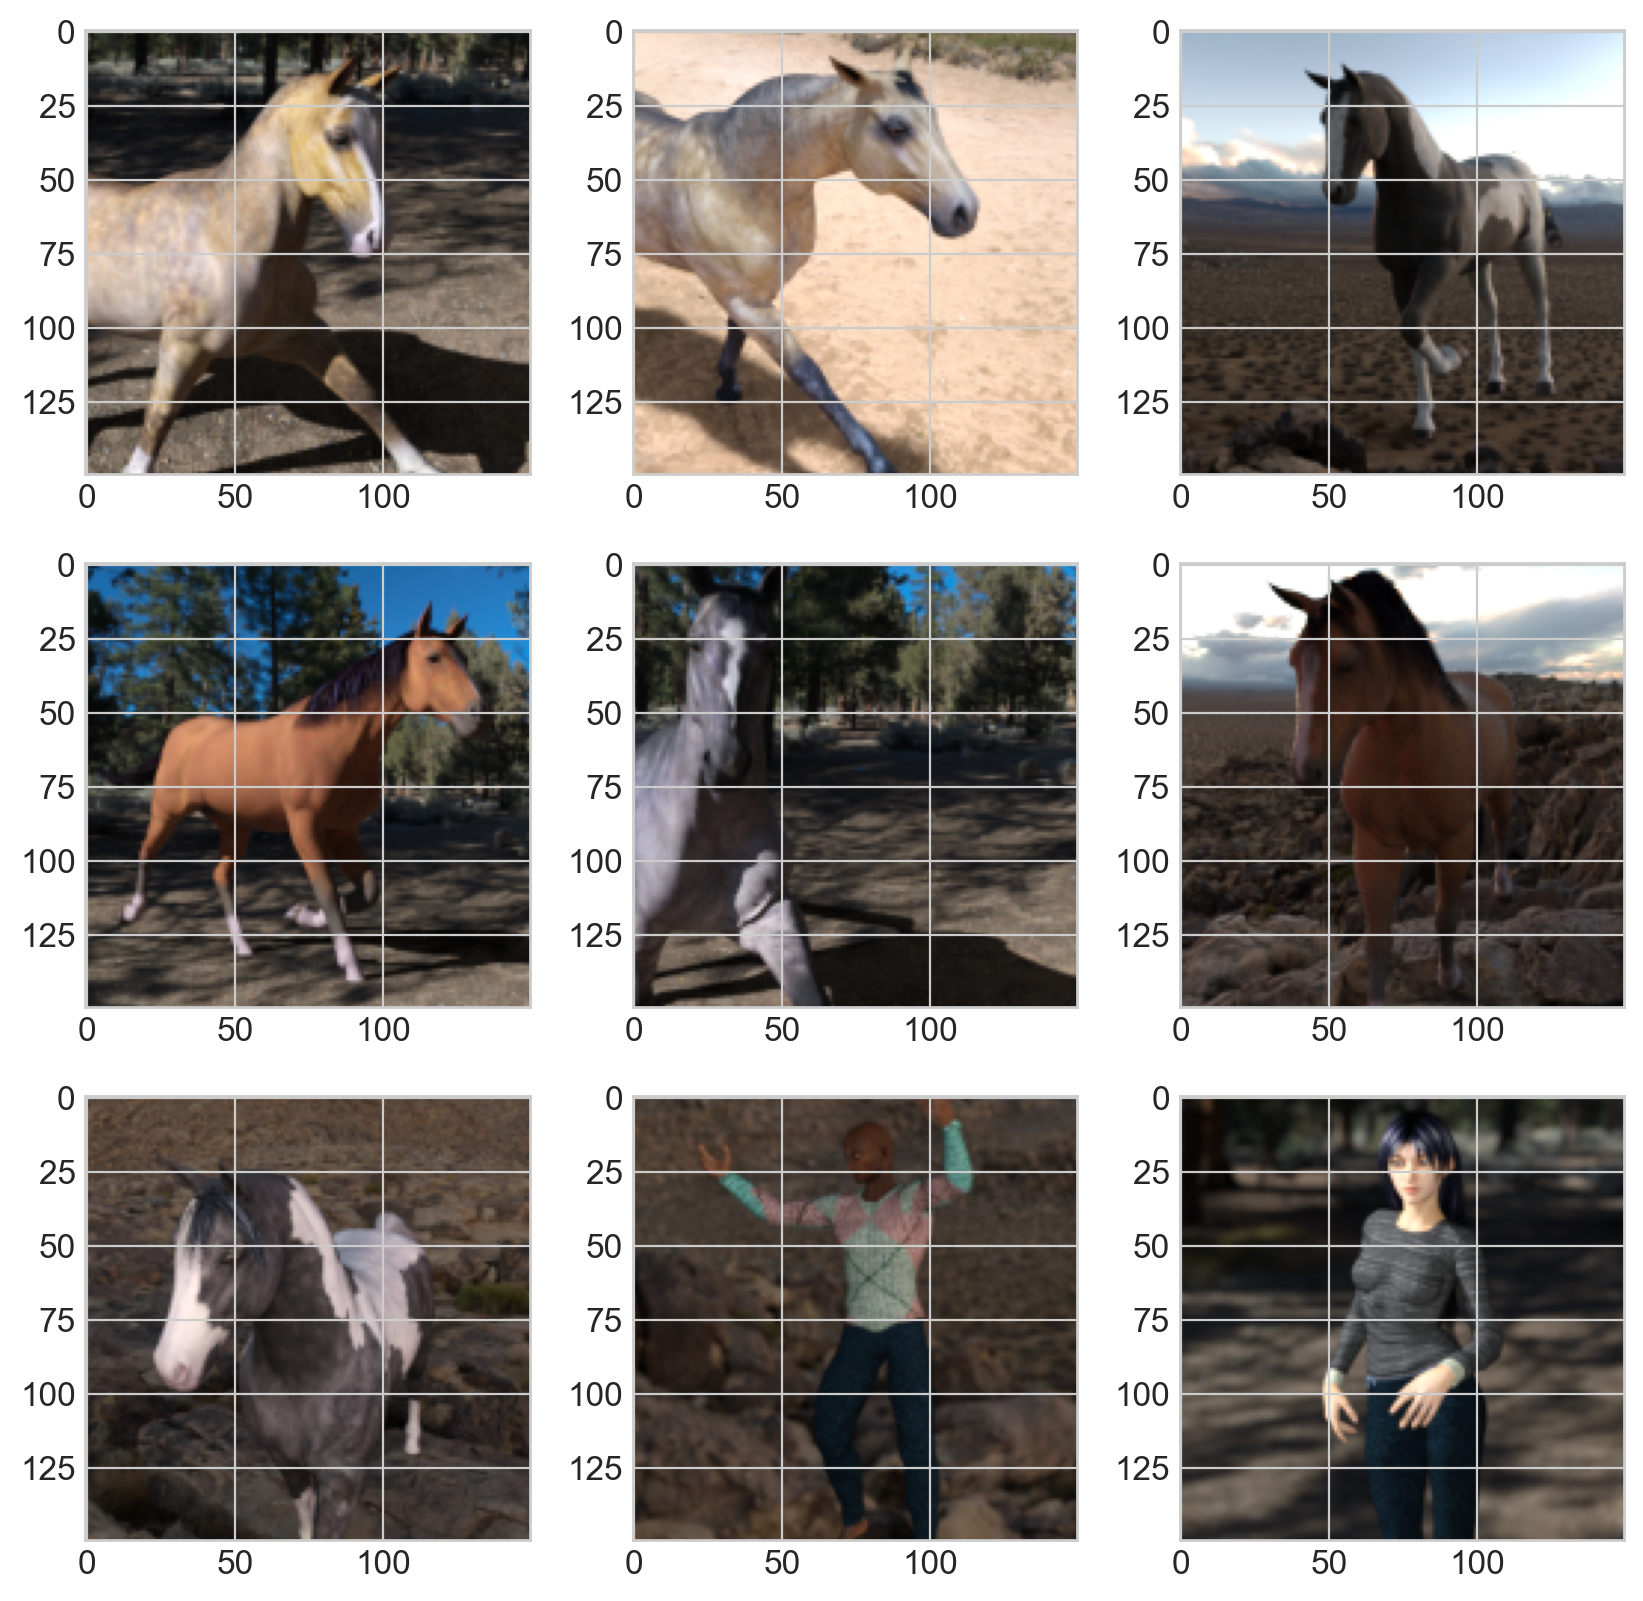

In [61]:
plt.figure(figsize=(10, 10))
count = 0
for i, label in train_ds.take(9):
    ax = plt.subplot(3, 3, count + 1)
    count += 1
    plt.imshow(i)

In [94]:
class myCallback(tf.keras.callbacks.Callback):
    """
    Define a Callback class that stops training once accuracy reaches 97.0%
    """

    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.97):
            print("\nReached 97.0% accuracy so cancelling training!")
            self.model.stop_training = True

In [95]:
# path_inception = f"{getcwd()}/../tmp2/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
# local_weights_file = path_inception

pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = 'imagenet') # Your Code Heredataset['test']

In [96]:
for layer in pre_trained_model.layers:
# Your Code Here
      layer.trainable = False
# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1128 (Conv2D)            (None, 74, 74, 32)   864         input_13[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1128 (Batch (None, 74, 74, 32)   96          conv2d_1128[0][0]                
__________________________________________________________________________________________________
activation_1128 (Activation)    (None, 74, 74, 32)   0           batch_normalization_1128[0][0]   
_______________________________________________________________________________________

In [106]:
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

In [111]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)
model = Model(pre_trained_model.input, resize_and_rescale,
                  data_augmentation, x)

model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [87]:
def transfer_model():
    """
    Build model with transfer learning
    """
    pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                    include_top=False,
                                    weights='imagenet')
    # Freeze the weights of the pre-trained layers
    for layer in pre_trained_model.layers:
        layer.trainable = False
    # Extract certain layer
    last_layer = pre_trained_model.get_layer('mixed7')
    last_output = last_layer.output
    
    # Flatten the output layer to 1 dimension
    x = layers.Flatten()(last_output)
    # Add a fully connected layer with 1,024 hidden units and ReLU activation
    x = layers.Dense(1024, activation='relu')(x)
    # Add a dropout rate of 0.2
    x = layers.Dropout(0.2)(x)
    # Add a final sigmoid layer for classification
    x = layers.Dense(1, activation='sigmoid')(x)

    model = Model(resize_and_rescale,
                  data_augmentation,
                  pre_trained_model.input, 
                  x
                 )

    model.compile(optimizer=RMSprop(lr=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [92]:
def train_model(save_model=False):
    callbacks = myCallback()
    history = model.fit(train_ds,
                        epochs=200,
                        callbacks=[callbacks],
                        validation_data=val_ds)

    if save_model:
        self.model.save("Transfer_binary_classify.h5")
        print(f"Model saved")

    return history

In [93]:
model = transfer_model()
history = train_model()

Epoch 1/200


NotImplementedError: in user code:

    /Users/ygong/Side_Projects/Models/conda-env-models/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /Users/ygong/Side_Projects/Models/conda-env-models/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/ygong/Side_Projects/Models/conda-env-models/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/ygong/Side_Projects/Models/conda-env-models/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/ygong/Side_Projects/Models/conda-env-models/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/ygong/Side_Projects/Models/conda-env-models/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /Users/ygong/Side_Projects/Models/conda-env-models/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /Users/ygong/Side_Projects/Models/conda-env-models/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/ygong/Side_Projects/Models/conda-env-models/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:459 call
        raise NotImplementedError('When subclassing the `Model` class, you should '

    NotImplementedError: When subclassing the `Model` class, you should implement a `call` method.
